In [4]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm
from xgcm import Grid

after running with `THICKNESS_CONFIG = "ISOMIP"` make ncfile

In [2]:
def make_thickness_file(filename):
    
    ic = xr.open_dataset('MOM_IC.nc')
    _, nz, ny, nx = ic.h.data.shape

    new_thick = nc.Dataset(filename, "w", format="NETCDF4")
    new_thick.createDimension("nz", nz)
    new_thick.createDimension("ny", ny)
    new_thick.createDimension("nx", nx)
    new_thick.createVariable("h","f8",("nz","ny","nx"))

    new_thick["h"][:,:,:] = ic.h.data
    new_thick.close()


In [3]:
make_thickness_file('INPUT/thickness_simpleshelf2_pfile.nc')

Now run with hack version of MOM6 and `THICKNESS_CONFIG = "thickness_simpleshelf2_pfile.nc"` by changing `MOM_override` 

(TODO: make the two runs and editing MOM_override happen automatically with a bash script)

Now plot the results and compare to the original with the salt/thickness bug.

In [11]:
!pwd

/Users/claireyung/mom6/MOM6-examples/ocean_only/seamount/simpleshelftest2-thicknesshackfix


In [12]:
ave = False ## True means use 5 daily average rather than hourly prog
basee = '/Users/claireyung/mom6/MOM6-examples/ocean_only/seamount/'
def open_files(folder):
    base = basee + folder
    if ave:
        prog = xr.open_dataset(base + '/ave_prog.nc')
    else:
        prog = xr.open_dataset(base + '/prog.nc')
    ocean_static = xr.open_dataset(base + "/ocean_geometry.nc")
    return prog, ocean_static
def open_IC(folder):
    base = basee + folder
    IC = xr.open_dataset(base + '/MOM_IC.nc')
    return IC
def open_Initialstate(folder):
    base = basee + folder
    IC = xr.open_dataset(base + '/Initial_state.nc')
    return IC

In [13]:
def plot(ax,yy0,tt,i,variable,varname,vmin1,vmax1,cmap,ymax):
    prog, ocean_static = open_files(label)
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = label
    depth = grid.interp(prog.e,'x')
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if varname == "uo": dataplot = dataplot[:,:,:,:-1]
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) 
    xi, yyi = np.meshgrid(xx[yy0,:], yi) 
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    
    plt.colorbar(cax, ax = ax, label = varname)
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


New
Old


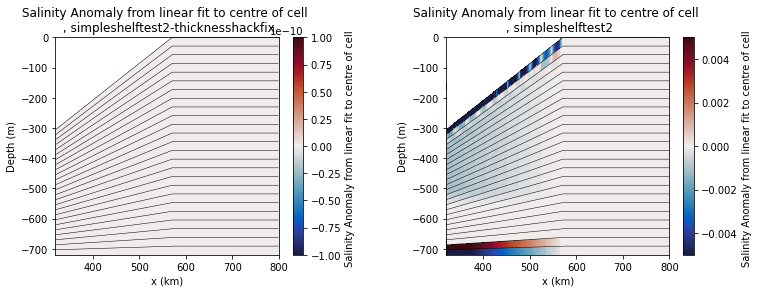

In [14]:
label = 'simpleshelftest2-thicknesshackfix'

fig, axes = plt.subplots(ncols = 2, figsize = (12,4))
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = -1
time = 0
ymax = 720
print('New')
ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
plot(axes[0],x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell \n",-1e-10,1e-10,cm.cm.balance,ymax)

print('Old')
label = 'simpleshelftest2'
prog, ocean_static = open_files(label)
IC = open_IC(label)
ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
plot(axes[1],x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell \n",-0.005,0.005,cm.cm.balance,ymax)

fig.subplots_adjust(wspace = 0.4)

Text(0.5, 1.0, 'old')

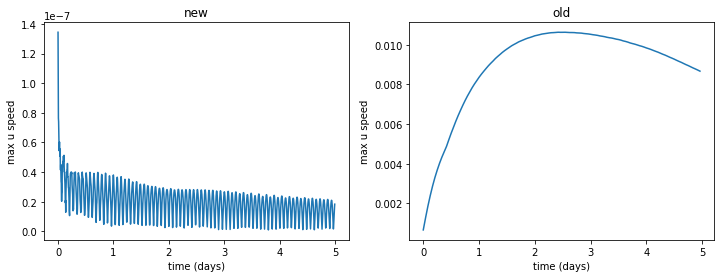

In [16]:
## Plot velocities
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))

label = 'simpleshelftest2-thicknesshackfix'
prog, ocean_static = open_files(label)
axes[0].plot(np.arange(len(prog.Time))/24/12,np.abs(prog.u).max(['zl','yh','xq'])) ## I saved all timesteps = 5 mins
axes[0].set_ylabel('max u speed')
axes[0].set_xlabel('time (days)')
axes[0].set_title('new')

label = 'simpleshelftest2'
prog, ocean_static = open_files(label)
axes[1].plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']))
axes[1].set_ylabel('max u speed')
axes[1].set_xlabel('time (days)')
axes[1].set_title('old')
